# Web Traffic Analysis
This covers the web traffic analysis of the iNethi network at three vantage points (mesh, school, servers)

In [67]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import calendar
from scipy.stats import describe
from scipy import stats
from user_agents import parse

import seaborn as sns
#sns.set(style="ticks", palette="pastel")

plt.style.use('default')

def hitCount(df, fieldname):
    df = df.groupby(['date']).count()[['ip_src']]
    df.index = pd.to_datetime(df.index, dayfirst=False,  errors='coerce')
    df.columns=[fieldname]
    df = df.resample('D').sum()
    df = df.reset_index()
    return df

def sumTraffic(df, fieldname):
    df = df.groupby(['date']).sum()[['frame_len']]
    df.index = pd.to_datetime(df.index, dayfirst=False,  errors='coerce')
    df.columns=[fieldname]
    df = df.resample('D').sum()
    df = df[[fieldname]].div(1e+9, axis=0)
    df = df.reset_index()
    return df

def extractLocalTraffic(df):
    df_local = df.loc[df.ip_src.str.startswith('10.2', na=False)]
    df_local = df_local.loc[df_local.ip_dst.str.startswith('10.', na=False)]
    return df_local

def extractGlobalTraffic(df):
    df_global = df.loc[~(df.ip_src.str.startswith('10.', na=False))]
    df_global = df_global.loc[df_global.ip_dst.str.startswith('10.', na=False)]
    return df_global

In [ ]:
df_mesh = pd.read_csv('data/stats/http/mesh.csv', sep=',', error_bad_lines=False, warn_bad_lines=False)
df_school = pd.read_csv('data/stats/http/school.csv', sep='|', error_bad_lines=False, warn_bad_lines=False)
df_servers = pd.read_csv('data/stats/http/servers.csv', sep='|', error_bad_lines=False, warn_bad_lines=False)

## User-agents
Study the different types of user-agents and extract the phone and browser used

In [4]:
df_uas = pd.DataFrame(columns=['ua', 'brand', 'os', 'browser', 'mobile', 'tablet', 'pc', 'bot','touch'])

ua_mesh_array = np.array(df_mesh.user_agent.unique())
ua_school_array = np.array(df_school.user_agent.unique())
ua_servers_array = np.array(df_servers.user_agent.unique())

ua_array = np.concatenate((ua_mesh_array, ua_school_array, ua_servers_array), axis=0)

ua_array = ua_array[~pd.isnull(ua_array)]

for ua_string in ua_array:
    user_agent = parse(ua_string)
    summary = str(user_agent)
    df_uas = df_uas.append({'ua' : ua_string, 
                           'brand': summary.split('/')[0] , 
                           'os': summary.split('/')[1] , 
                           'browser': summary.split('/')[2], 
                           'mobile': user_agent.is_mobile, 
                           'tablet': user_agent.is_tablet , 
                           'pc': user_agent.is_pc, 
                           'bot': user_agent.is_bot,
                           'touch': user_agent.is_touch_capable}, ignore_index=True)
df_uas.head()

,ua,brand,os,browser,mobile,tablet,pc,bot,touch
0,Avast NCC,Other,Other,Other,False,False,False,False,False
1,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,PC,Linux,Chrome 60.0.3112,False,False,True,False,False
2,Dalvik/1.6.0 (Linux; U; Android 4.3; GT-I9500 ...,Samsung GT-I9500,Android 4.3,Android 4.3,False,True,False,False,True
3,Dalvik/2.1.0 (Linux; U; Android 8.1.0; ASTRO B...,ASTRO,Android 8.1.0,Android 8.1.0,False,True,False,False,True
4,Dalvik/2.1.0 (Linux; U; Android 7.0; S61 JAZZ ...,S61 JAZZ,Android 7.0,Android 7.0,False,True,False,False,True


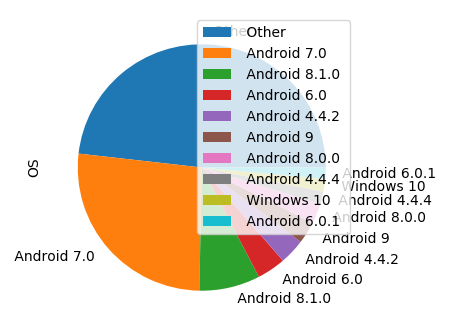

In [7]:
#fig, ax = plt.subplots(figsize=(5, 5))

ax = df_uas.groupby(['os']).count()[['ua']].sort_values('ua', ascending=False)[:10].plot(x='os', y='ua', kind='pie', label='OS', figsize=(4, 4))

# plt.legend(loc='best')
# plt.savefig('plots/pie_os_distribution.pdf')
# plt.show()


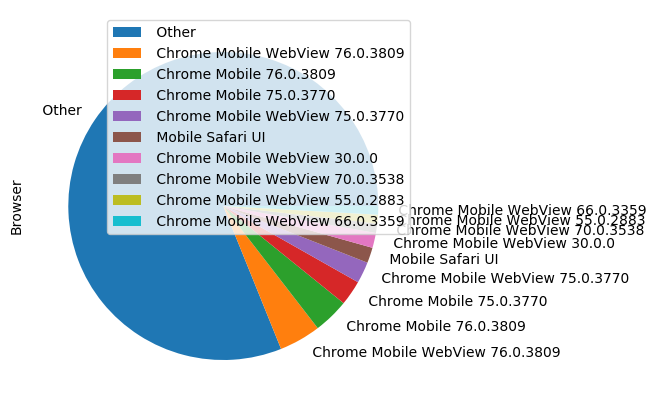

In [8]:
df_browser = df_uas.loc[~df_uas.browser.str.startswith(' Android')]

df_browser.groupby(['browser']).count()[['ua']].sort_values('ua', ascending=False)[:10].plot(x='browser', y='ua', kind='pie', figsize=(5, 5), label='Browser')

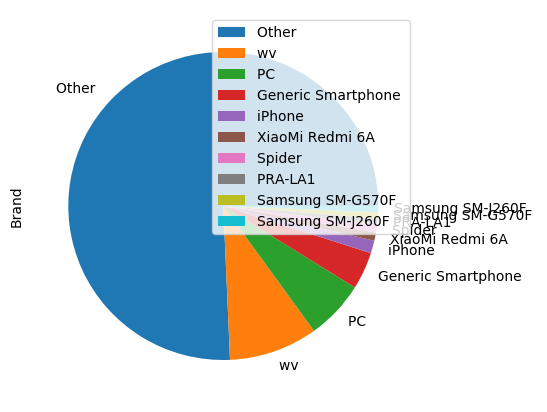

In [9]:
df_browser.groupby(['brand']).count()[['ua']].sort_values('ua', ascending=False)[:10].plot(x='brand', y='ua', kind='pie', figsize=(5, 5), label='Brand')

### Hits on local vs global services

In [68]:
df_local_mesh = extractLocalTraffic(df_mesh)
df_global_mesh = extractGlobalTraffic(df_mesh)

In [69]:
df_local_mesh_sum = sumTraffic(df_local_mesh, 'traffic')
df_global_mesh_sum = sumTraffic(df_global_mesh, 'traffic')

In [70]:
df_local_school = extractLocalTraffic(df_school)
df_global_school = extractGlobalTraffic(df_school)
df_local_school_sum = sumTraffic(df_local_school, 'traffic')
df_global_school_sum = sumTraffic(df_global_school, 'traffic')

#### Mesh Local vs External traffic

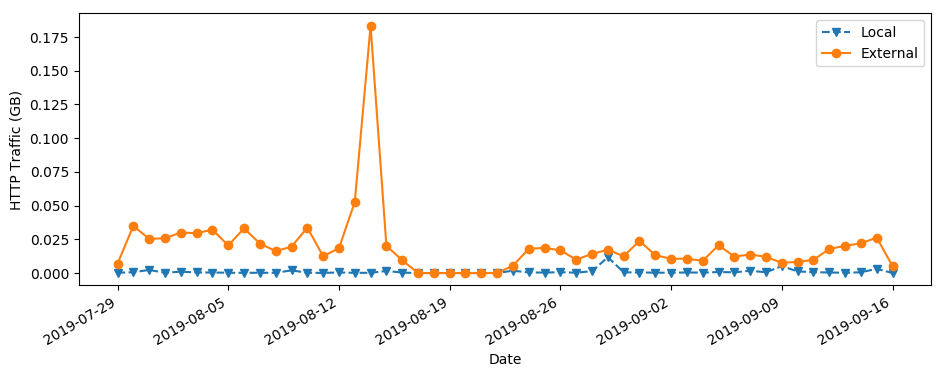

In [71]:
fig, ax = plt.subplots(figsize=(11, 4))

# df_local_mesh.plot(ax, x="date", y=["mesh"], kind="line", marker='.', linestyle='-', )
# df_local_school.plot(ax, x="date", y=["school"], kind="line", marker='.', linestyle='-')
# df_local_servers.plot(ax, x="date", y=["servers"], kind="line", marker='.', linestyle='-')

ax.plot(df_local_mesh_sum.date, df_local_mesh_sum.traffic, marker='v', linestyle='--', label='Local')
ax.plot(df_global_mesh_sum.date, df_global_mesh_sum.traffic, marker='o', linestyle='-', label='External')

ax.set_ylabel('HTTP Traffic (GB)')
ax.set_xlabel('Date')
#ax.set_yscale('symlog')
fig.autofmt_xdate()

ax.legend()

plt.savefig('plots/http_daily_traffic_mesh.pdf')
plt.show()

#### School Local vs External traffic

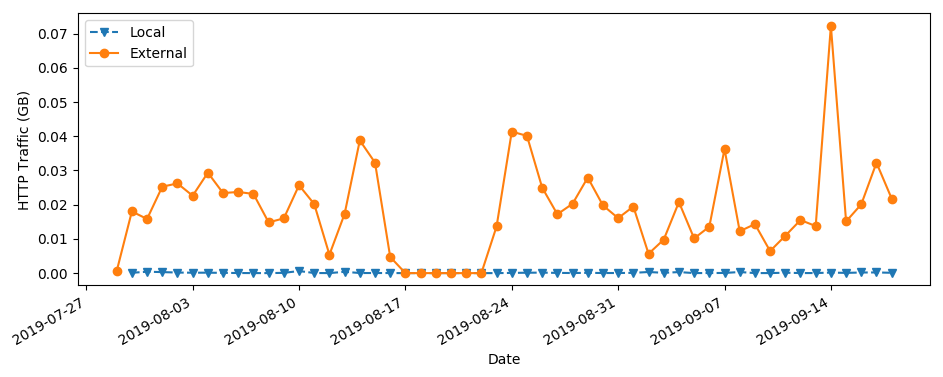

In [75]:
fig, ax = plt.subplots(figsize=(11, 4))

ax.plot(df_local_school_sum.date, df_local_school_sum.traffic, marker='v', linestyle='--', label='Local')
ax.plot(df_global_school_sum.date, df_global_school_sum.traffic, marker='o', linestyle='-', label='External')

ax.set_ylabel('HTTP Traffic (GB)')
ax.set_xlabel('Date')
#ax.set_yscale('log')
fig.autofmt_xdate()

ax.legend()

plt.savefig('plots/http_daily_traffic_school.pdf')
plt.show()

#### Servers Local vs External

In [76]:
df_local_servers = extractLocalTraffic(df_servers)
df_global_servers = extractGlobalTraffic(df_servers)
df_local_servers_sum = sumTraffic(df_local_servers, 'traffic')
df_global_servers_sum = sumTraffic(df_global_servers, 'traffic')

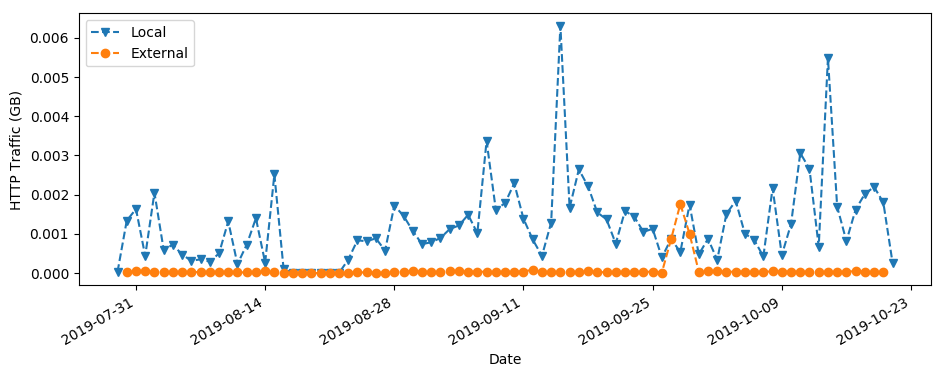

In [77]:
fig, ax = plt.subplots(figsize=(11, 4))

ax.plot(df_local_servers_sum.date, df_local_servers_sum.traffic, marker='v', linestyle='--', label='Local')
ax.plot(df_global_servers_sum.date, df_global_servers_sum.traffic, marker='o', linestyle='--', label='External')

ax.set_ylabel('HTTP Traffic (GB)')
ax.set_xlabel('Date')
#ax.set_yscale('log')
fig.autofmt_xdate()

ax.legend()

plt.savefig('plots/http_daily_traffic_servers.pdf')
plt.show()

### Most visited websites (External)
#### Mesh

In [78]:
df_hosts = [df_mesh.iloc[:,[3,7]], df_school.iloc[:,[4,8]]]
df_hosts = pd.concat(df_hosts, sort=True)
df_hosts = df_hosts.dropna().drop_duplicates()
df_hosts = df_hosts.loc[~df_hosts.host.str.contains(':')]

In [79]:
df_hosts.head()

,host,ip_dst
0,cdn.samsungcloudsolution.com,143.204.65.189
44,ncc.avast.com,105.225.1.226
70,cdn.samsungcloudsolution.com,143.204.65.208
93,connectivitycheck.gstatic.com,216.58.223.131
121,play.googleapis.com,172.217.170.74


In [80]:
df_global_mesh = df_global_mesh.merge(df_hosts, how='left', left_on='ip_src', right_on='ip_dst')

In [81]:
df_global_mesh.head()

,date,ip_src,srcport,ip_dst_x,dstport,request_version,request_method,host_x,request_uri,user_agent,response_code,content_type,content_length,location,referer,request_full_uri,frame_len,http_time,host_y,ip_dst_y
0,2019-07-29 19:35:24,143.204.65.189,80.0,10.10.161.49,33081.0,NaN,NaN,NaN,NaN,NaN,302.0,text/html; charset=UTF-8,NaN,http://10.10.0.1:8002/index.php?zone=inethimes...,NaN,NaN,492.0,0.0,cdn.samsungcloudsolution.com,143.204.65.189
1,2019-07-29 19:35:24,143.204.65.189,80.0,10.10.161.49,33081.0,NaN,NaN,NaN,NaN,NaN,302.0,text/html; charset=UTF-8,NaN,http://10.10.0.1:8002/index.php?zone=inethimes...,NaN,NaN,492.0,0.0,location.tappsgames.com,143.204.65.189
2,2019-07-29 19:35:25,143.204.65.189,80.0,10.10.161.49,33082.0,NaN,NaN,NaN,NaN,NaN,302.0,text/html; charset=UTF-8,NaN,http://10.10.0.1:8002/index.php?zone=inethimes...,NaN,NaN,492.0,0.0,cdn.samsungcloudsolution.com,143.204.65.189
3,2019-07-29 19:35:25,143.204.65.189,80.0,10.10.161.49,33082.0,NaN,NaN,NaN,NaN,NaN,302.0,text/html; charset=UTF-8,NaN,http://10.10.0.1:8002/index.php?zone=inethimes...,NaN,NaN,492.0,0.0,location.tappsgames.com,143.204.65.189
4,2019-07-29 19:35:26,143.204.65.189,80.0,10.10.161.49,33083.0,NaN,NaN,NaN,NaN,NaN,302.0,text/html; charset=UTF-8,NaN,http://10.10.0.1:8002/index.php?zone=inethimes...,NaN,NaN,492.0,0.0,cdn.samsungcloudsolution.com,143.204.65.189


In [82]:
#df_global_mesh['short_host'] = df_global_mesh.apply(lambda x: '.'.join(x.host.split('.')[-2:]), axis=1)
df_mv_hosts = df_global_mesh.groupby(['host_y']).sum()[['frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts = df_mv_hosts.reset_index()
df_mv_hosts['frame_len'] = df_mv_hosts.frame_len/1e+9

df_mv_hosts['short_host'] = df_mv_hosts.apply(lambda x: '.'.join(x.host_y.split('.')[-2:]), axis=1)
df_mv_hosts = df_mv_hosts.groupby(['short_host']).sum()[['frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts = df_mv_hosts.reset_index()

df_mh_hosts = df_global_mesh.groupby(['host_y']).count()[['ip_src']]
df_mh_hosts.sort_values(['ip_src'], ascending=False, inplace=True)
df_mh_hosts = df_mh_hosts.reset_index()
df_mh_hosts['short_host'] = df_mh_hosts.apply(lambda x: '.'.join(x.host_y.split('.')[-2:]), axis=1)
df_mh_hosts = df_mh_hosts.groupby(['short_host']).sum()[['ip_src']]
df_mh_hosts.sort_values(['ip_src'], ascending=False, inplace=True)
df_mh_hosts = df_mh_hosts.reset_index()

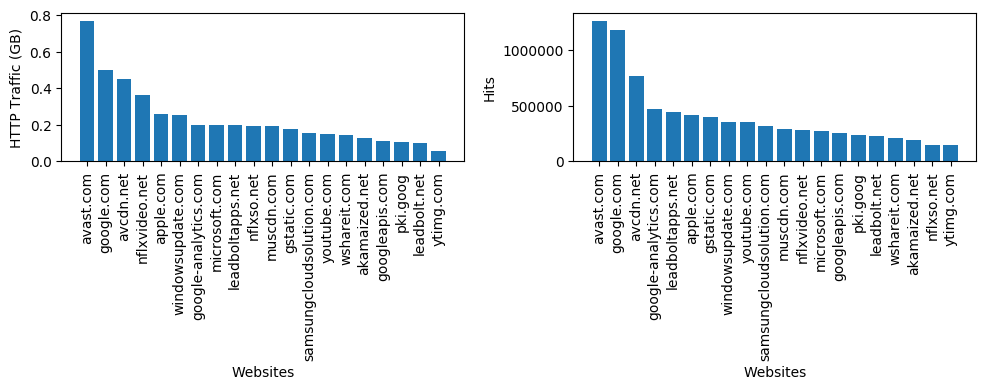

In [83]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,4))

df_list1 = df_mv_hosts[:20]
df_list2 = df_mh_hosts[:20]

axes[0].bar(df_list1.short_host, df_list1.frame_len)
axes[1].bar(df_list2.short_host, df_list2.ip_src)

axes[0].set_ylabel('HTTP Traffic (GB)')
axes[0].set_xlabel('Websites')

axes[1].set_ylabel('Hits')
axes[1].set_xlabel('Websites')

for ax in axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)

#plt.xticks(fontsize=10, rotation='vertical')

fig.tight_layout()

plt.savefig('plots/http_traffic_mesh.pdf')
plt.show()


#### School

In [53]:
df_global_school = df_global_school.merge(df_hosts, how='left', left_on='ip_src', right_on='ip_dst')
df_mv_hosts = df_global_school.groupby(['host_y'], as_index=False).sum()[['host_y','frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts['short_host'] = df_mv_hosts.apply(lambda x: '.'.join(x.host_y.split('.')[-2:]), axis=1)
df_mv_hosts = df_mv_hosts.groupby(['short_host'], as_index=False).sum()[['short_host','frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts['frame_len'] = df_mv_hosts.frame_len/1e+9

df_mh_hosts = df_global_school.groupby(['host_y'], as_index=False).count()[['host_y','ip_src']]
df_mh_hosts.sort_values(['ip_src'], ascending=False, inplace=True)
df_mh_hosts['short_host'] = df_mh_hosts.apply(lambda x: '.'.join(x.host_y.split('.')[-2:]), axis=1)
df_mh_hosts = df_mh_hosts.groupby(['short_host'], as_index=False).sum()[['short_host','ip_src']]
df_mh_hosts.sort_values(['ip_src'], ascending=False, inplace=True)

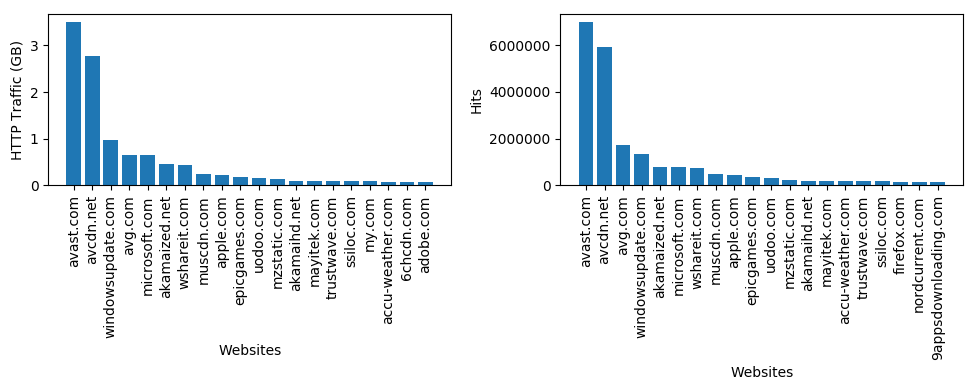

In [55]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,4))

df_list1 = df_mv_hosts[:20]
df_list2 = df_mh_hosts[:20]

axes[0].bar(df_list1.short_host, df_list1.frame_len)
axes[1].bar(df_list2.short_host, df_list2.ip_src)

axes[0].set_ylabel('HTTP Traffic (GB)')
axes[0].set_xlabel('Websites')

axes[1].set_ylabel('Hits')
axes[1].set_xlabel('Websites')

for ax in axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)

#plt.xticks(fontsize=10, rotation='vertical')

fig.tight_layout()

plt.savefig('plots/http_traffic_school.pdf')
plt.show()


#### Servers

In [64]:
df_global_servers = df_global_servers.merge(df_hosts, how='left', left_on='ip_src', right_on='ip_dst')
df_mv_hosts = df_global_servers.groupby(['host_y'], as_index=False).sum()[['host_y','frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts['short_host'] = df_mv_hosts.apply(lambda x: '.'.join(x.host_y.split('.')[-2:]), axis=1)
df_mv_hosts = df_mv_hosts.groupby(['short_host'], as_index=False).sum()[['short_host','frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts['frame_len'] = df_mv_hosts.frame_len/1e+9

df_mh_hosts = df_global_servers.groupby(['host_y'], as_index=False).count()[['host_y','ip_src']]
df_mh_hosts.sort_values(['ip_src'], ascending=False, inplace=True)
df_mh_hosts['short_host'] = df_mh_hosts.apply(lambda x: '.'.join(x.host_y.split('.')[-2:]), axis=1)
df_mh_hosts = df_mh_hosts.groupby(['short_host'], as_index=False).sum()[['short_host','ip_src']]
df_mh_hosts.sort_values(['ip_src'], ascending=False, inplace=True)

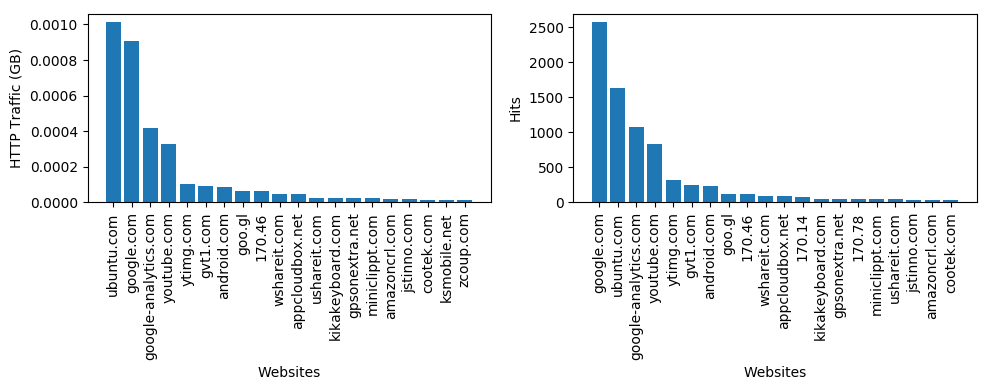

In [65]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,4))

df_list1 = df_mv_hosts[:20]
df_list2 = df_mh_hosts[:20]

axes[0].bar(df_list1.short_host, df_list1.frame_len)
axes[1].bar(df_list2.short_host, df_list2.ip_src)

axes[0].set_ylabel('HTTP Traffic (GB)')
axes[0].set_xlabel('Websites')

axes[1].set_ylabel('Hits')
axes[1].set_xlabel('Websites')

for ax in axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)

#plt.xticks(fontsize=10, rotation='vertical')

fig.tight_layout()

plt.savefig('plots/http_traffic_servers.pdf')
plt.show()


### Most visited websites (Internal)

In [84]:
df_mv_hosts = df_local_mesh.groupby(['ip_src'], as_index=False).sum()[['ip_src','frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts['frame_len'] = df_mv_hosts.frame_len/1e+9

df_mh_hosts = df_local_mesh.groupby(['ip_src'], as_index=False).count()[['ip_src','date']]
df_mh_hosts.sort_values(['date'], ascending=False, inplace=True)

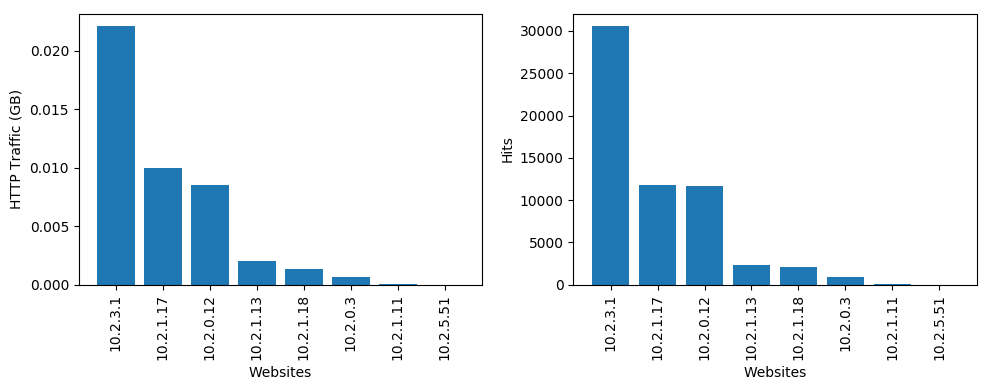

In [86]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,4))

df_list1 = df_mv_hosts[:20]
df_list2 = df_mh_hosts[:20]

axes[0].bar(df_list1.ip_src, df_list1.frame_len)
axes[1].bar(df_list2.ip_src, df_list2.date)

axes[0].set_ylabel('HTTP Traffic (GB)')
axes[0].set_xlabel('Websites')

axes[1].set_ylabel('Hits')
axes[1].set_xlabel('Websites')

for ax in axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)

#plt.xticks(fontsize=10, rotation='vertical')

fig.tight_layout()

plt.savefig('plots/http_traffic_mesh_local.pdf')
plt.show()


In [87]:
df_mv_hosts = df_local_school.groupby(['ip_src'], as_index=False).sum()[['ip_src','frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts['frame_len'] = df_mv_hosts.frame_len/1e+9

df_mh_hosts = df_local_school.groupby(['ip_src'], as_index=False).count()[['ip_src','date']]
df_mh_hosts.sort_values(['date'], ascending=False, inplace=True)

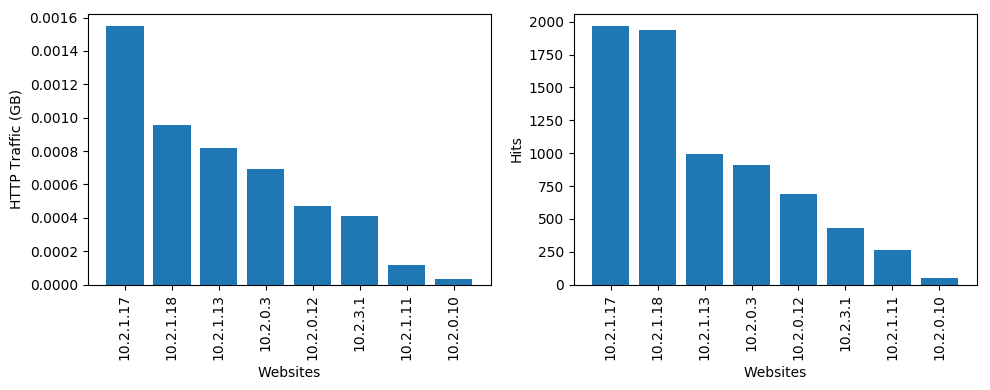

In [88]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,4))

df_list1 = df_mv_hosts[:20]
df_list2 = df_mh_hosts[:20]

axes[0].bar(df_list1.ip_src, df_list1.frame_len)
axes[1].bar(df_list2.ip_src, df_list2.date)

axes[0].set_ylabel('HTTP Traffic (GB)')
axes[0].set_xlabel('Websites')

axes[1].set_ylabel('Hits')
axes[1].set_xlabel('Websites')

for ax in axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)

#plt.xticks(fontsize=10, rotation='vertical')

fig.tight_layout()

plt.savefig('plots/http_traffic_school_local.pdf')
plt.show()
